In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

In [3]:
df = pd.read_csv('Groceries_dataset.csv')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

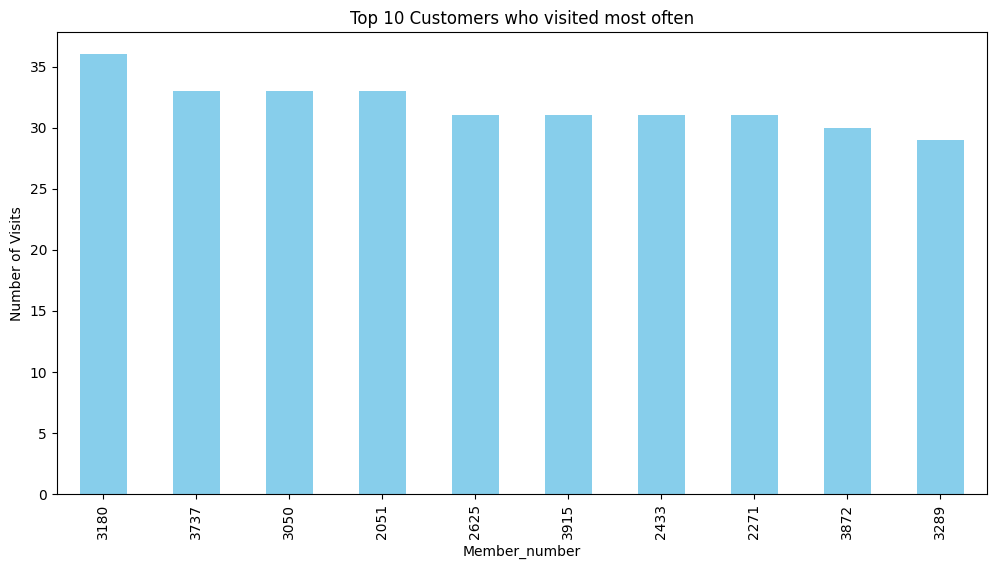

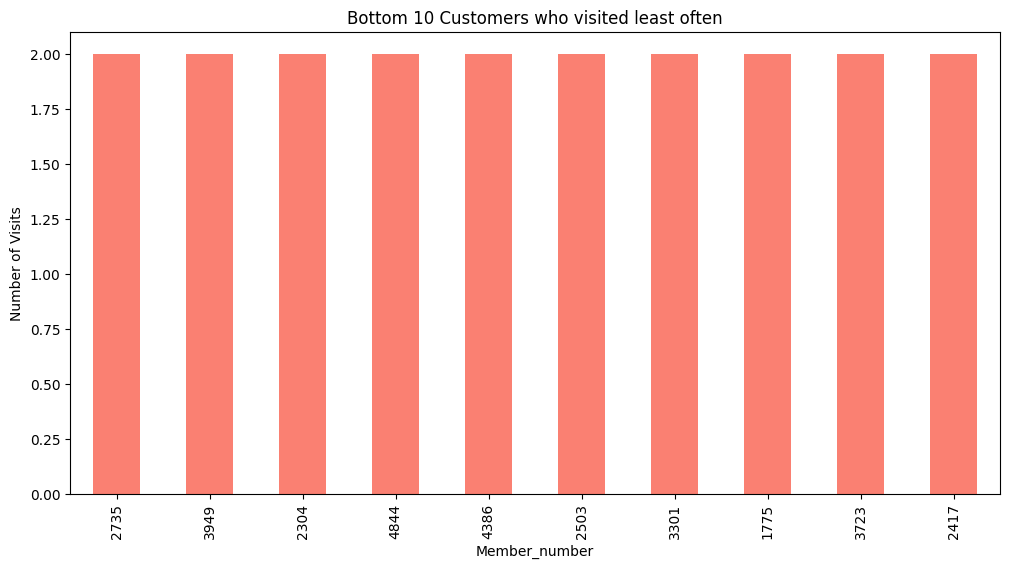

In [4]:
customer_visits = df['Member_number'].value_counts()
plt.figure(figsize=(12, 6))
customer_visits.head(10).plot(kind='bar', color='skyblue', title='Top 10 Customers who visited most often')
plt.ylabel('Number of Visits')
plt.show()

plt.figure(figsize=(12, 6))
customer_visits.tail(10).plot(kind='bar', color='salmon', title='Bottom 10 Customers who visited least often')
plt.ylabel('Number of Visits')
plt.show()

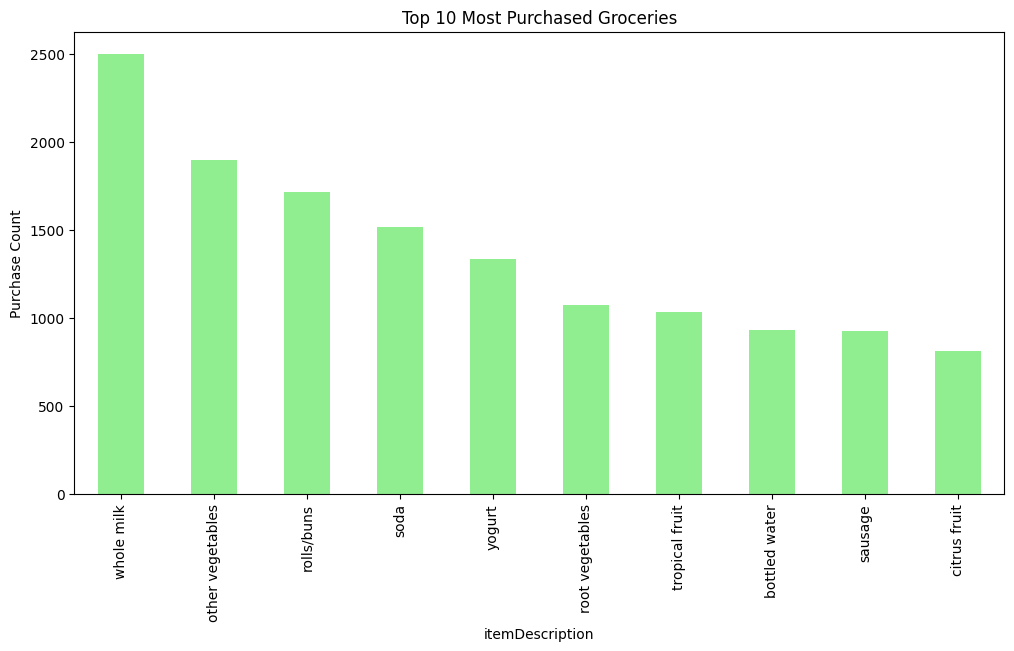

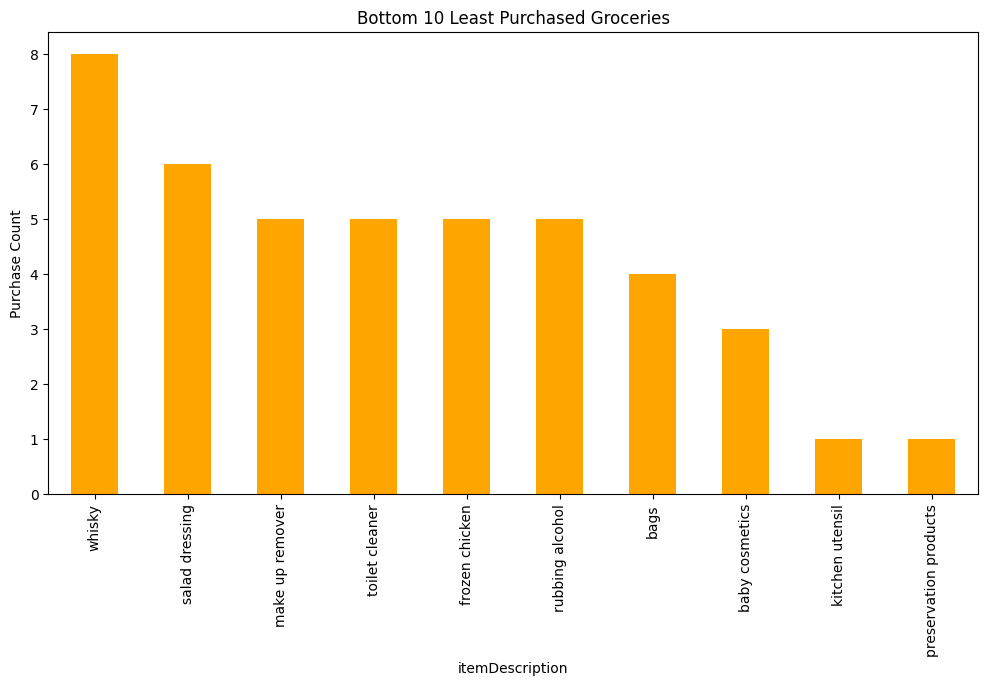

In [5]:
item_counts = df['itemDescription'].value_counts()
plt.figure(figsize=(12, 6))
item_counts.head(10).plot(kind='bar', color='lightgreen', title='Top 10 Most Purchased Groceries')
plt.ylabel('Purchase Count')
plt.show()

plt.figure(figsize=(12, 6))
item_counts.tail(10).plot(kind='bar', color='orange', title='Bottom 10 Least Purchased Groceries')
plt.ylabel('Purchase Count')
plt.show()

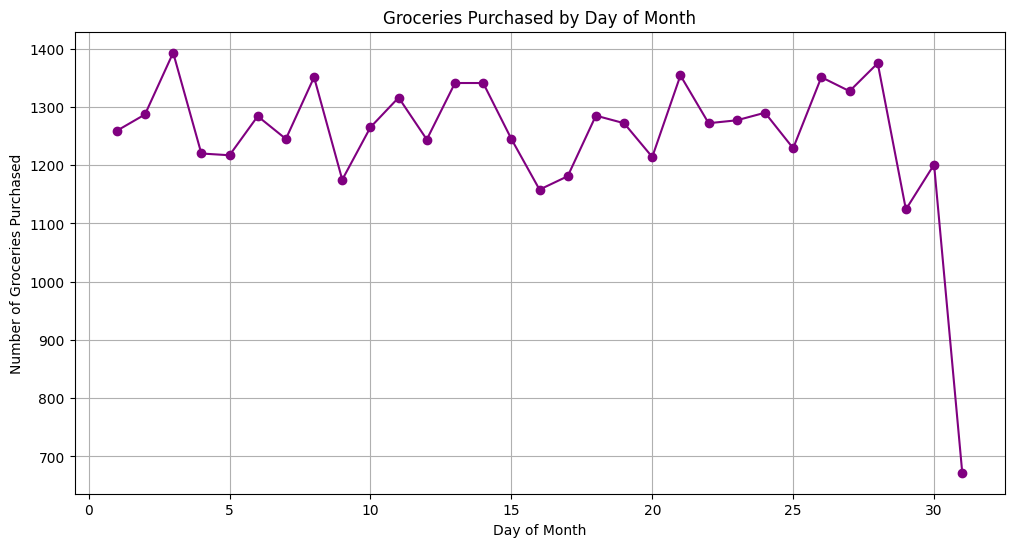

In [6]:
df['Day'] = df['Date'].dt.day
daily_counts = df.groupby('Day')['itemDescription'].count()
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', color='purple', title='Groceries Purchased by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Groceries Purchased')
plt.grid(True)
plt.show()

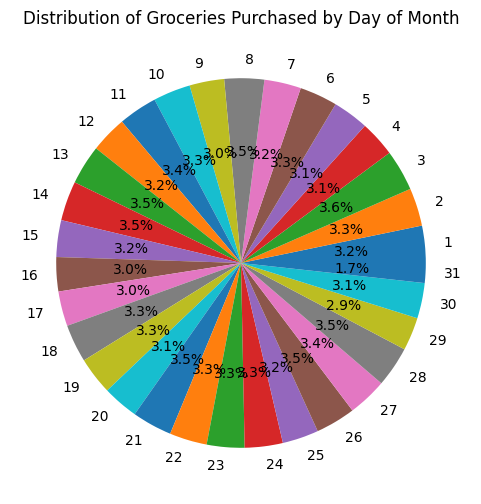

In [16]:
plt.figure(figsize=(6, 6))
daily_counts.plot(kind='pie', autopct='%1.1f%%', title='Distribution of Groceries Purchased by Day of Month')
plt.ylabel('')
plt.show()


In [12]:
transactions = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).tolist()

min_support = 0.005  
min_confidence = 0.1  
min_support_count = min_support * len(transactions)

def count_items(transactions, itemsets):
    counts = defaultdict(int)
    for itemset in itemsets:
        for transaction in transactions:
            if itemset.issubset(transaction):
                counts[itemset] += 1
    return counts

def get_frequent_itemsets(transactions, min_support_count):
    # Get single items
    single_items = set()
    for transaction in transactions:
        for item in transaction:
            single_items.add(frozenset([item]))
    
    item_counts = count_items(transactions, single_items)
    freq_itemsets = {k: v for k, v in item_counts.items() if v >= min_support_count}
    
    k = 2
    while True:
        items = list(freq_itemsets.keys())
        candidates = set()
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                candidate = items[i].union(items[j])
                if len(candidate) == k:
                    candidates.add(candidate)
        
        if not candidates:
            break
        
        candidate_counts = count_items(transactions, candidates)
        
        new_freq_itemsets = {k: v for k, v in candidate_counts.items() if v >= min_support_count}
        if not new_freq_itemsets:
            break
            
        freq_itemsets.update(new_freq_itemsets)
        k += 1
    
    return freq_itemsets

def generate_rules(freq_itemsets, transactions, min_confidence):
    rules = []
    total_transactions = len(transactions)
    
    for itemset, itemset_count in freq_itemsets.items():
        if len(itemset) > 1:
            all_subsets = []
            for i in range(1, len(itemset)):
                all_subsets.extend([frozenset(x) for x in combinations(itemset, i)])
            
            for antecedent in all_subsets:
                consequent = itemset - antecedent
                
                antecedent_count = sum(1 for t in transactions if antecedent.issubset(t))
                consequent_count = sum(1 for t in transactions if consequent.issubset(t))
                
                support = itemset_count / total_transactions
                confidence = itemset_count / antecedent_count
                lift = (itemset_count / antecedent_count) / (consequent_count / total_transactions)
                
                if confidence >= min_confidence:
                    rules.append({
                        'antecedent': antecedent,
                        'consequent': consequent,
                        'support': support,
                        'confidence': confidence,
                        'lift': lift
                    })
    return rules

Frequent Itemsets Count: 126

Top 10 Association Rules sorted by Lift:
         antecedent          consequent   support  confidence      lift
6     (frankfurter)  (other vegetables)  0.005146    0.136283  1.116150
8    (bottled beer)        (whole milk)  0.007151    0.157817  0.999330
10        (sausage)        (whole milk)  0.008955    0.148394  0.939663
11     (newspapers)        (whole milk)  0.005614    0.144330  0.913926
14  (domestic eggs)        (whole milk)  0.005280    0.142342  0.901341
2     (frankfurter)        (whole milk)  0.005280    0.139823  0.885388
13           (pork)        (whole milk)  0.005012    0.135135  0.855703
15      (pip fruit)        (whole milk)  0.006616    0.134877  0.854071
5    (citrus fruit)        (whole milk)  0.007151    0.134591  0.852259
3   (shopping bags)        (whole milk)  0.006349    0.133427  0.844887


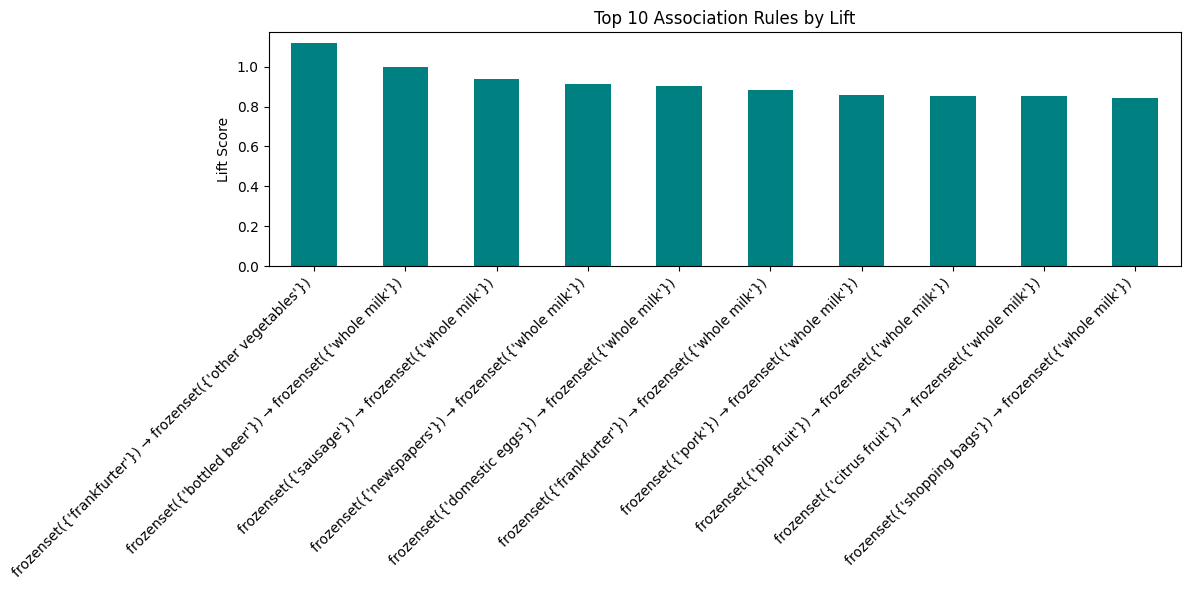

In [13]:
freq_itemsets = get_frequent_itemsets(transactions, min_support_count)

rules = generate_rules(freq_itemsets, transactions, min_confidence)

if rules:  
    rules_df = pd.DataFrame(rules)
    
    rules_sorted = rules_df.sort_values(by='lift', ascending=False)
    
    print("Frequent Itemsets Count:", len(freq_itemsets))
    print("\nTop 10 Association Rules sorted by Lift:")
    print(rules_sorted[['antecedent', 'consequent', 'support', 'confidence', 'lift']].head(10))
    
    plt.figure(figsize=(12, 6))
    rules_sorted.head(10)['lift'].plot(kind='bar', color='teal')
    plt.title('Top 10 Association Rules by Lift')
    plt.ylabel('Lift Score')
    plt.xticks(range(10), [f"{ant} → {con}" for ant, con in zip(rules_sorted['antecedent'].head(10), 
                          rules_sorted['consequent'].head(10))], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No association rules met the minimum confidence threshold. Try lowering min_confidence or min_support.")